<div align="center">
    <h1>🔬 Rilevamento del Grado di Ruggine nel Metallo con YOLO11 🔬</h1>
    <p><i>Un sistema di visione artificiale per il monitoraggio della corrosione</i></p>
    <a href="https://colab.research.google.com/github/RubbinRubbin/ia_inspector/blob/main/ia_inspector.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
</div>

---

Questo notebook implementa un sistema di rilevamento e classificazione dei gradi di ruggine su superfici metalliche utilizzando il modello YOLO11. Il sistema è in grado di identificare diverse categorie di ruggine e fornire una valutazione della severità della corrosione.

**Autore:** RubbinRubbin  
**Data creazione:** Maggio 2025  
**Ultima modifica:** Maggio 2025

# 🔧 1. Setup dell'ambiente

In questa sezione configuriamo l'ambiente di lavoro, verificando l'accesso alla GPU e installando le librerie necessarie per l'addestramento del modello di rilevamento della ruggine. L'utilizzo della GPU è essenziale per addestrare efficientemente modelli di deep learning come YOLO11.

**Operazioni principali:**
- Verifica dell'accesso alle risorse GPU
- Installazione di Ultralytics YOLO11
- Configurazione delle directory di lavoro
- Installazione delle dipendenze aggiuntive

In [1]:
# Verifichiamo l'accesso alla GPU con nvidia-smi
!nvidia-smi

# Definiamo la directory HOME per gestire facilmente dataset, immagini e modelli
import os
HOME = os.getcwd()
print(HOME)

Fri May  2 13:48:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.5/112.6 GB disk)


In [3]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

# Installiamo Roboflow per accedere ai dataset
!pip install roboflow

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets


# 📥 2. Importazione del dataset da Roboflow

Qui accediamo a un dataset di immagini di superfici metalliche con vari gradi di ruggine utilizzando l'API di Roboflow. Il dataset contiene immagini annotate che mostrano differenti livelli di corrosione, permettendoci di addestrare un modello per rilevare e classificare accuratamente la ruggine.

**Operazioni principali:**
- Installazione della libreria Roboflow
- Autenticazione all'API di Roboflow
- Download del dataset sulla ruggine in formato compatibile con YOLO11
- Esplorazione della struttura e composizione del dataset

In [4]:
from roboflow import Roboflow

# Tua API key Roboflow
rf = Roboflow(api_key="YOUR API KEY")

# Workspace e progetto del dataset #1 (10 072 immagini, instance‑seg)
project = rf.workspace("rust-detection").project("rust-detection-38s6e")

# Versione v1 del 28‑03‑2023
version = project.version(1)

# Export in formato YOLOv11 (include maschere di segmentazione nei .txt)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Rust-Detection-1 in yolov11:: 100%|██████████| 20138/20138 [00:04<00:00, 4419.68it/s]


# 🛠️ 3. Preparazione dei dati per YOLO11

In questa sezione adattiamo il dataset scaricato al formato richiesto da YOLO11. Configuriamo correttamente i percorsi nel file data.yaml e verifichiamo che la struttura delle directory sia appropriata per l'addestramento.

**Operazioni principali:**
- Configurazione del file data.yaml
- Organizzazione delle directory di train, validation e test
- Verifica della struttura delle annotazioni
- Adattamento dei percorsi per la compatibilità con YOLO11

In [5]:
# Modifichiamo il file data.yaml per essere compatibile con YOLO11
!sed -i '$d' {dataset.location}/data.yaml   # Eliminiamo l'ultima riga
!sed -i '$d' {dataset.location}/data.yaml   # Eliminiamo la penultima riga
!sed -i '$d' {dataset.location}/data.yaml   # Eliminiamo la terzultima riga

# Aggiungiamo i percorsi corretti per i set di test, train e validazione
!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

# 🧠 4. Training del modello YOLO11

Questa sezione è dedicata all'addestramento del modello YOLO11 sui dati di ruggine. Utilizziamo il modello pre-addestrato yolo11s.pt come punto di partenza (transfer learning) e lo addestriamo ulteriormente per riconoscere specificamente i diversi gradi di ruggine.

**Operazioni principali:**
- Configurazione dei parametri di addestramento
- Caricamento del modello base pre-addestrato
- Processo di addestramento con monitoraggio delle metriche
- Visualizzazione dell'andamento del training in tempo reale

In [7]:
%cd {HOME}

# Avviamo il training con YOLO11
!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/Rust-Detection-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

# 📊 5. Valutazione sul set di validazione

Dopo l'addestramento, è fondamentale valutare le prestazioni del modello su dati che non ha mai visto durante il training. In questa sezione, analizziamo quanto bene il modello rileva e classifica i diversi gradi di ruggine sul set di validazione.

**Operazioni principali:**
- Valutazione del modello addestrato sul set di validazione
- Analisi delle metriche di performance (mAP, precisione, recall)
- Esame della matrice di confusione
- Valutazione delle performance per classe (diversi livelli di ruggine)

In [8]:
# Validazione del modello addestrato
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1118.9±511.0 MB/s, size: 57.2 KB)
val: Scanning /content/Rust-Detection-1/valid/labels.cache... 295 images, 47 backgrounds, 0 corrupt: 100% 295/295 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 802, len(boxes) = 1125. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0% 0/19 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/__init__.py", line 988, in

# 🔍 6. Inferenza sul set di test

In questa sezione, utilizziamo il modello addestrato per fare predizioni su immagini completamente nuove dal set di test. Questo simula l'utilizzo del modello in un ambiente reale e ci permette di valutare la sua efficacia pratica nel rilevamento della ruggine.

**Operazioni principali:**
- Caricamento del miglior modello addestrato
- Configurazione dei parametri di inferenza e soglia di confidenza
- Esecuzione delle predizioni sul set di test
- Salvataggio delle immagini con le rilevazioni visualizzate

In [9]:
# Utilizziamo il modello per fare predizioni sul set di test
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/296 /content/Rust-Detection-1/test/images/0_original_corrosion_detected-1-_png_jpg.rf.a1114d6b02ccdeb68c731b83aafd95e5.jpg: 640x640 2 Corrosions, 15.6ms
image 2/296 /content/Rust-Detection-1/test/images/0_original_corrosion_detected-1-_png_jpg.rf.d5ff0efdb26bd1028915fb30199e6bec.jpg: 640x640 (no detections), 15.7ms
image 3/296 /content/Rust-Detection-1/test/images/101806006_13067922921_jpg.rf.f53fd18aa237b7dfa8e32ebaefd9e0f9.jpg: 640x640 (no detections), 15.6ms
image 4/296 /content/Rust-Detection-1/test/images/1_original_corrosion_detected-1-_png_jpg.rf.6ac2ff21d119dd11b65bd228ab7b6303.jpg: 640x640 2 Corrosions, 15.6ms
image 5/296 /content/Rust-Detection-1/test/images/1_original_corrosion_detected-1-_png_jpg.rf.72b77bf36f720fc482fa8acedaab1642.jpg: 640x640 1 Corrosion, 15.6ms
image 6/296 /content/Rust-Detection-1

# 📈 7. Visualizzazione e analisi dei risultati

Questa sezione è dedicata alla visualizzazione dettagliata e all'analisi dei risultati del nostro modello. Esaminiamo sia le metriche quantitative che esempi visivi delle predizioni per comprendere meglio i punti di forza e le limitazioni del sistema.

**Operazioni principali:**
- Visualizzazione degli esempi di rilevazione più rappresentativi
- Analisi statistica della distribuzione dei gradi di ruggine rilevati
- Creazione di grafici riassuntivi delle performance del modello
- Identificazione di pattern e casi problematici

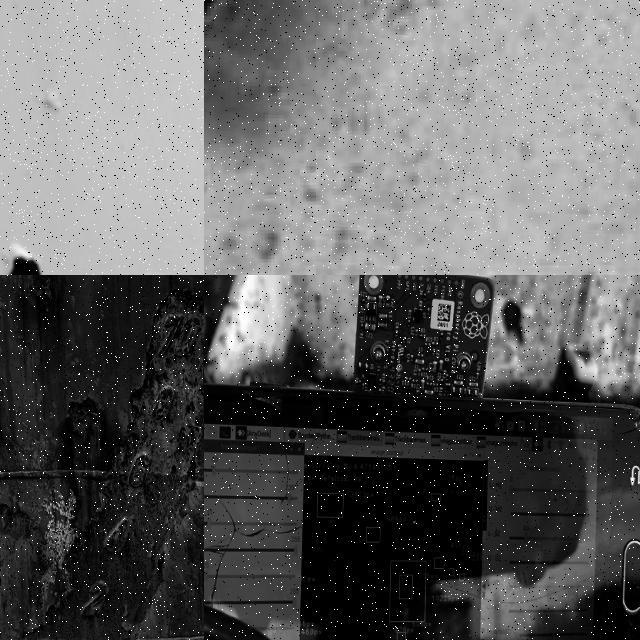

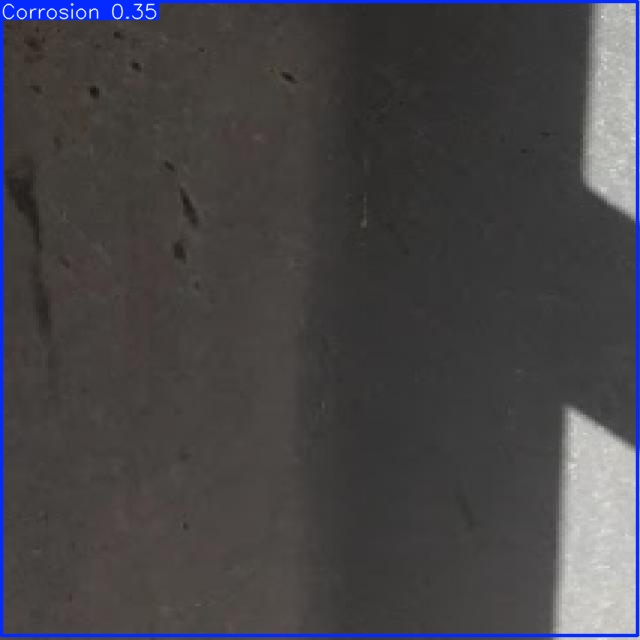

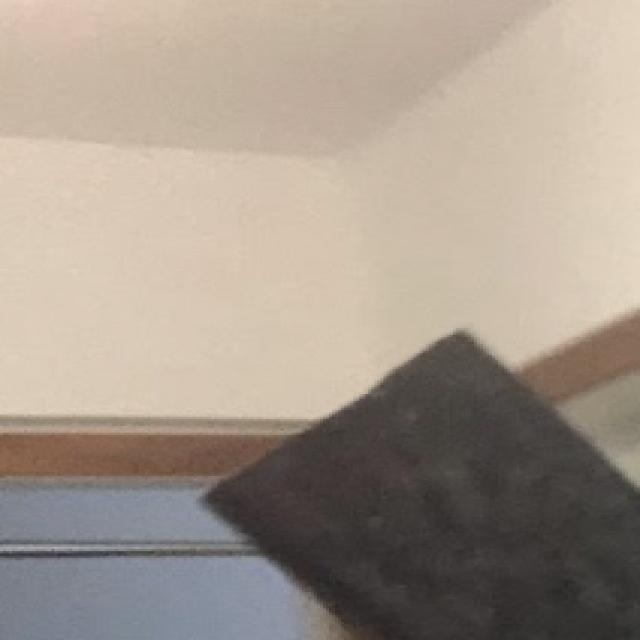

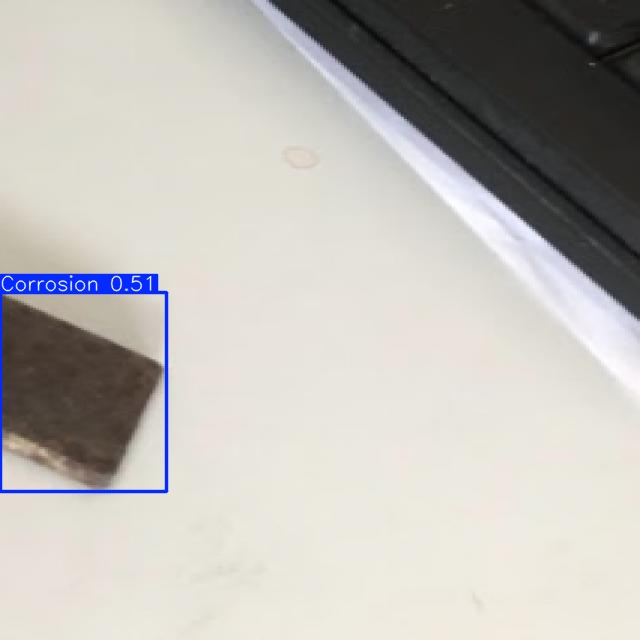

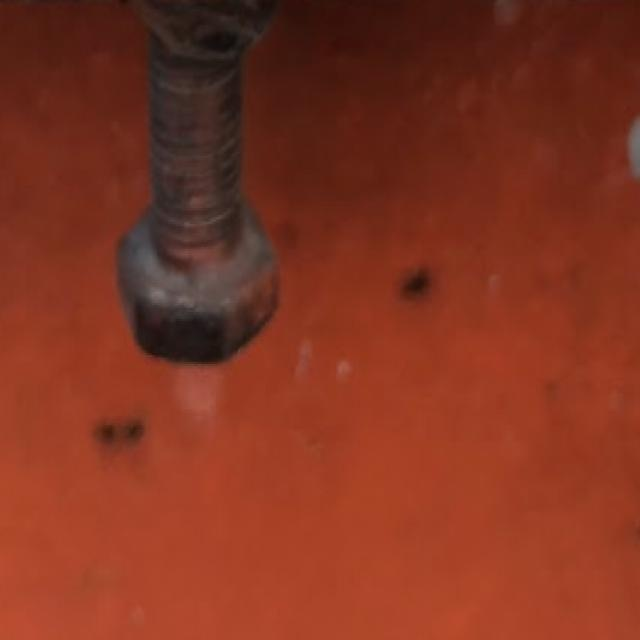

In [13]:
# Visualizziamo alcuni risultati
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:5]:  # Mostriamo le prime 5 immagini
    display(IPyImage(filename=img, width=600))
    print("\n")

# 🏁 9. Conclusioni e sviluppi futuri

In questa sezione finale, riassumiamo i risultati ottenuti dal nostro sistema di rilevamento della ruggine e discutiamo possibili miglioramenti e sviluppi futuri per rendere il sistema ancora più efficace.

**Punti chiave:**
- Riepilogo delle performance del modello addestrato
- Limitazioni attuali del sistema
- Potenziali miglioramenti (più dati, architetture alternative, ecc.)
- Possibili applicazioni pratiche in contesti industriali e in fotogrammetria